In [1]:
import torch # type: ignore

if __name__ == "__main__":
    print(torch.__version__)
    # Setup device agnostic code
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"Using device: {device}")

2.3.0+cpu
Using device: cpu


In [2]:
import torch


class TinyModel(torch.nn.Module):

    def __init__(self):
        super(TinyModel, self).__init__()

        self.linear1 = torch.nn.Linear(100, 200)
        self.activation = torch.nn.ReLU()
        self.linear2 = torch.nn.Linear(200, 10)
        self.softmax = torch.nn.Softmax()

    def forward(self, x):
        x = self.linear1(x)
        x = self.activation(x)
        x = self.linear2(x)
        x = self.softmax(x)
        return x


tinymodel = TinyModel()

print('The model:')
print(tinymodel)

print('\n\nJust one layer:')
print(tinymodel.linear2)

print('\n\nModel params:')
for param in tinymodel.parameters():
    print(param)

print('\n\nLayer params:')
for param in tinymodel.linear2.parameters():
    print(param)

The model:
TinyModel(
  (linear1): Linear(in_features=100, out_features=200, bias=True)
  (activation): ReLU()
  (linear2): Linear(in_features=200, out_features=10, bias=True)
  (softmax): Softmax(dim=None)
)


Just one layer:
Linear(in_features=200, out_features=10, bias=True)


Model params:
Parameter containing:
tensor([[-0.0923,  0.0333, -0.0900,  ..., -0.0675, -0.0047,  0.0873],
        [-0.0146, -0.0310,  0.0644,  ...,  0.0143, -0.0487, -0.0433],
        [-0.0833,  0.0484, -0.0755,  ...,  0.0413,  0.0275, -0.0353],
        ...,
        [-0.0843, -0.0177,  0.0054,  ..., -0.0752, -0.0066, -0.0202],
        [ 0.0113,  0.0908, -0.0784,  ...,  0.0843,  0.0939, -0.0249],
        [-0.0149,  0.0009, -0.0201,  ...,  0.0959,  0.0997, -0.0040]],
       requires_grad=True)
Parameter containing:
tensor([-0.0065,  0.0285, -0.0186, -0.0276,  0.0414, -0.0571,  0.0835, -0.0327,
        -0.0767,  0.0320,  0.0786,  0.0022, -0.0944,  0.0383, -0.0579,  0.0107,
         0.0165,  0.0876, -0.0749, -0.09

In [3]:
import torch.nn.functional as F


class LeNet(torch.nn.Module):

    def __init__(self):
        super(LeNet, self).__init__()
        # 1 input image channel (black & white), 6 output channels, 5x5 square convolution
        # kernel
        self.conv1 = torch.nn.Conv2d(1, 6, 5)
        self.conv2 = torch.nn.Conv2d(6, 16, 3)
        # an affine operation: y = Wx + b
        self.fc1 = torch.nn.Linear(16 * 6 * 6, 120)  # 6*6 from image dimension
        self.fc2 = torch.nn.Linear(120, 84)
        self.fc3 = torch.nn.Linear(84, 10)

    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        # If the size is a square you can only specify a single number
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

In [4]:
from torch import nn  # type: ignore
import torch.nn.functional as F # type: ignore


class MySmallModel(nn.Module):
    def __init__(self):
        super(MySmallModel, self).__init__()
        self.fc1 = nn.Linear(5, 2)
        self.fc2 = nn.Linear(2, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.network1 = MySmallModel()
        self.network2 = MySmallModel()
        self.network3 = MySmallModel()

        self.fc1 = nn.Linear(3, 2)
        self.fc_out = nn.Linear(2, 1)

    def forward(self, x1, x2, x3):
        x1 = F.relu(self.network1(x1))
        x2 = F.relu(self.network2(x2))
        x3 = F.relu(self.network3(x3))

        x = torch.cat((x1, x2, x3), 1)
        x = F.relu(self.fc1(x))
        x = self.fc_out(x)
        return x


model = MyModel()
N = 10
x1, x2, x3 = torch.randn(N, 5), torch.randn(N, 5), torch.randn(N, 5)

output = model(x1, x2, x3)

## Sparse Model Validation 

### Parameterisation of Feature Size and Group Feature Size

In [129]:
class GroupLayer(nn.Module):
    def __init__(self, group_feat_size: int):
        super(GroupLayer, self).__init__()
        self.fc1 = nn.Linear(group_feat_size, 1)
    def forward(self, x):
        x = F.relu(self.fc1(x))
        return x 

class TorchModel(nn.Module):
    def __init__(self, group_feat_size: int, total_feat_size: int):
        super(TorchModel, self).__init__()
        self.group_feat_size = group_feat_size
        self.total_feat_size = total_feat_size
        num_groups = self.total_feat_size // self.group_feat_size
        # if num_groups not an integer, throw error
        if num_groups != self.total_feat_size / self.group_feat_size:
            raise ValueError("Total feature size must be divisible by group feature size")
        
        self.num_groups = num_groups
        self.group_layers = nn.ModuleList()
        i = 0 
        while i < num_groups:
            self.group_layers.append(GroupLayer(group_feat_size))
            i += 1
            
        self.layer_2_size = int(num_groups / 2)
        
        self.fc1 = nn.Linear(num_groups, self.layer_2_size)
        self.fc_out = nn.Linear(self.layer_2_size, 1)
        

    def forward(self, input_data):
        # print(input_data.shape)
        xs = []
        i = 0
        while i < self.total_feat_size:
            xs.append(input_data[:, i:i+self.group_feat_size])
            i += group_feat_size
        
        outs = []
        for i,x in enumerate(xs):
            # print(i+1, x.shape)
            outs.append(self.group_layers[i](x))

        x = torch.cat(outs, 1)
        x = F.relu(self.fc1(x))
        x = self.fc_out(x)
        return x
    

group_feat_size = 10
total_feat_size = 260

model = TorchModel(group_feat_size, total_feat_size)
N = 10
x = torch.randn(N, total_feat_size)
output = model(x)
print(output)
print(model)

tensor([[0.1208],
        [0.1936],
        [0.1864],
        [0.2696],
        [0.0661],
        [0.2202],
        [0.1334],
        [0.1326],
        [0.2051],
        [0.1475]], grad_fn=<AddmmBackward0>)
TorchModel(
  (group_layers): ModuleList(
    (0-25): 26 x GroupLayer(
      (fc1): Linear(in_features=10, out_features=1, bias=True)
    )
  )
  (fc1): Linear(in_features=26, out_features=13, bias=True)
  (fc_out): Linear(in_features=13, out_features=1, bias=True)
)


### Model Optimisation Validation 

In [177]:
# use sklearn to generate some regression data

from torch.utils.data import DataLoader
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split

X, y = make_regression(n_samples=10000, n_features=260, noise=0.1)
y = y.reshape(-1, 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

train_dl = DataLoader(list(zip(X_train, y_train)), batch_size=32, shuffle=True)
test_dl = DataLoader(list(zip(X_test, y_test)), batch_size=32, shuffle=False)

In [178]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.MSELoss()

model = TorchModel(group_feat_size, total_feat_size)


In [180]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
criterion = torch.nn.MSELoss()

def train(model, train_dl, optimizer, criterion, epochs=10):
    running_loss = 0.0
    for epoch in range(epochs):
        print(f"### Epoch {epoch}")
        for i, (x, y) in enumerate(train_dl):
            optimizer.zero_grad()
            output = model(x)
            loss = criterion(output, y)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            print(f"Batch {i} loss: {loss.item()}")
            
    return running_loss / len(train_dl)
                            

train(model, train_dl, optimizer, criterion)

### Epoch 0
Batch 0 loss: 43265.95334051589
Batch 1 loss: 43769.70668765815
Batch 2 loss: 51063.13610698151
Batch 3 loss: 31887.078673868826
Batch 4 loss: 27212.87292946202
Batch 5 loss: 21852.101070121345
Batch 6 loss: 39404.01740497344
Batch 7 loss: 33454.19728695883
Batch 8 loss: 29582.177416267456
Batch 9 loss: 53554.742290062364
Batch 10 loss: 27230.351765344778
Batch 11 loss: 42616.03873473134
Batch 12 loss: 23140.837882220338
Batch 13 loss: 27290.00810295282
Batch 14 loss: 46852.48649854868
Batch 15 loss: 33112.50350914469
Batch 16 loss: 28583.38737521213
Batch 17 loss: 32850.4925280198
Batch 18 loss: 36527.66924541115
Batch 19 loss: 33230.5215310286
Batch 20 loss: 41223.033694636484
Batch 21 loss: 54027.38169258549
Batch 22 loss: 38549.625888154056
Batch 23 loss: 38897.8306342196
Batch 24 loss: 36914.090484084416
Batch 25 loss: 40052.6211180996
Batch 26 loss: 39344.606266426286
Batch 27 loss: 38337.501599303745
Batch 28 loss: 38634.78469499729
Batch 29 loss: 29934.59573211414
B

380638.296480749

In [137]:
# plot the output against the target

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(4, 4))
plt.scatter(y_test, output.detach().numpy())
plt.xlabel('True Value')
plt.ylabel('Predicted Value')
plt.title('Predicted vs True Value')
plt.show()

TypeError: forward() missing 1 required positional argument: 'input_data'

### Trying skorch

In [8]:
from skorch import NeuralNetRegressor
from torch import nn  # type: ignore
import torch.nn.functional as F  # type: ignore

class GroupLayer(nn.Module):

    def __init__(self, group_feat_size: int):
        super(GroupLayer, self).__init__()
        self.fc1 = nn.Linear(group_feat_size, 1).double()

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return x

class TorchModel(nn.Module):

    def __init__(self, group_feat_size: int, total_feat_size: int):

        super(TorchModel, self).__init__()
        self.group_feat_size = group_feat_size
        self.total_feat_size = total_feat_size

        num_groups = self.total_feat_size // self.group_feat_size

        # if num_groups not an integer, throw error
        if num_groups != self.total_feat_size / self.group_feat_size:
            raise ValueError("Total feature size must be divisible by group feature size")

        self.num_groups = num_groups
        self.group_layers = nn.ModuleList()
        i = 0
        while i < num_groups:
            self.group_layers.append(GroupLayer(group_feat_size))
            i += 1
        self.layer_2_size = int(num_groups / 2)
        self.fc1 = nn.Linear(num_groups, self.layer_2_size).double()
        self.fc_out = nn.Linear(self.layer_2_size, 1).double()


    def forward(self, input_data):

        # print(input_data.shape)

        xs = []
        i = 0
        while i < self.total_feat_size:
            xs.append(input_data[:, i:i+self.group_feat_size])
            i += group_feat_size


        outs = []
        for i, x in enumerate(xs):
            # print(i+1, x.shape)
            outs.append(self.group_layers[i](x))


        x = torch.cat(outs, 1)
        x = F.relu(self.fc1(x))
        x = self.fc_out(x)
        return x



group_feat_size = 10
total_feat_size = 260

net = NeuralNetRegressor(
    TorchModel,
    module__group_feat_size=group_feat_size,
    module__total_feat_size=total_feat_size,
    optimizer=torch.optim.Adam,
    criterion=torch.nn.MSELoss,
    max_epochs=20,
    lr=0.001,
    batch_size=32,
    iterator_train__shuffle=True
)


In [9]:
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split

X, y = make_regression(n_samples=2000, n_features=260, noise=0.01)
y = y.reshape(-1, 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [10]:
net.fit(X_train, y_train)

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1    44220.1780    41889.8243  0.2841
      2    44217.0392    41888.1898  0.2816
      3    44213.2126    41885.4407  0.4046
      4    44207.1179    41878.1976  0.2894
      5    44195.1706    41864.8819  0.3597
      6    44171.7564    41831.5821  0.3213
      7    44114.1985    41757.8835  0.2898
      8    43991.0618    41613.0394  0.2901
      9    43773.5824    41377.8202  0.2817
     10    43432.8481    41025.9599  0.2767
     11    42951.5874    40571.1405  0.2775
     12    42314.6568    39983.1273  0.2840
     13    41505.3027    39251.0583  0.3642
     14    40515.5702    38337.4193  0.2965
     15    39319.2995    37272.9808  0.3049
     16    37918.3252    36104.4874  0.2923
     17    36355.2355    34759.9018  0.2877
     18    34654.7682    33326.3728  0.2810
     19    32792.4481    31790.2439  0.2804
     20    30846.2020    30226.4489  0.3557


<class 'skorch.regressor.NeuralNetRegressor'>[initialized](
  module_=TorchModel(
    (group_layers): ModuleList(
      (0-25): 26 x GroupLayer(
        (fc1): Linear(in_features=10, out_features=1, bias=True)
      )
    )
    (fc1): Linear(in_features=26, out_features=13, bias=True)
    (fc_out): Linear(in_features=13, out_features=1, bias=True)
  ),
)

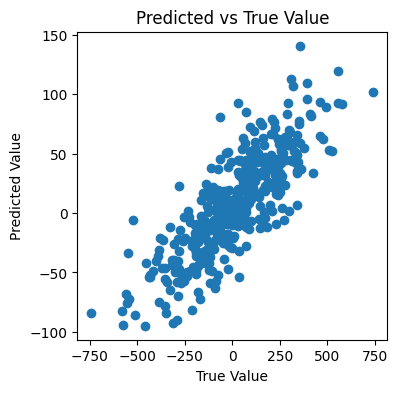

In [11]:
# make prediction 

y_pred = net.predict(X_test)

# plot the output against the target

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(4, 4))
plt.scatter(y_test, y_pred)
plt.xlabel('True Value')
plt.ylabel('Predicted Value')
plt.title('Predicted vs True Value')
plt.show()

## Data Integration Validation 

In [12]:
import os

import numpy as np
import pandas as pd

path = os.getcwd()
# find the string 'project' in the path, return index
index_project = path.find('project')
# slice the path from the index of 'project' to the end
project_path = path[:index_project+7]
# set the working directory
os.chdir(project_path)
print(f'Project path set to: {os.getcwd()}')
# Bring in CCLE data


Project path set to: c:\Github\ode-biomarker-project


In [13]:
from PathLoader import PathLoader
from DataLink import DataLink
path_loader = PathLoader('data_config.env', 'current_user.env')
data_link = DataLink(path_loader, 'data_codes.csv')


In [14]:
# load in original ccle data
loading_code = 'generic-gdsc-1-FGFR_0939-LN_IC50-fgfr4_ccle_dynamic_features-true-Row'
# generic-gdsc-{number}-{drug_name}-{target_label}-{dataset_name}-{replace_index}-{row_index}
feature_data, label_data = data_link.get_data_using_code(loading_code)

In [31]:
feature_data

,pAkt_auc,pAkt_median,pAkt_tfc,pAkt_tmax,pAkt_max,pAkt_tmin,pAkt_min,pAkt_ttsv,pAkt_tsv,pAkt_init,...,amTORC2_auc,amTORC2_median,amTORC2_tfc,amTORC2_tmax,amTORC2_max,amTORC2_tmin,amTORC2_min,amTORC2_ttsv,amTORC2_tsv,amTORC2_init
SIDM01085,0.019410,0.021032,4.682872,1.0,0.032885,0.04,0.005787,0.04,0.005787,0.005787,...,0.001717,0.001599,5.486629,1,0.003834,0.04,0.000591,0.04,0.000591,0.000591
SIDM00949,0.077292,0.084704,9.089875,1.0,0.140803,0.04,0.013955,0.04,0.013955,0.013955,...,0.218305,0.226915,0.364546,1,0.264206,0.04,0.193622,0.04,0.193622,0.193622
SIDM00494,0.010086,0.011210,3.560627,1.0,0.015136,0.04,0.003319,0.04,0.003319,0.003319,...,0.019850,0.020458,0.403167,1,0.024825,0.04,0.017692,0.04,0.017692,0.017692
SIDM00377,0.036978,0.039602,5.138051,1.0,0.065341,0.04,0.010645,0.04,0.010645,0.010645,...,0.000361,0.000332,1.189183,1,0.000639,0.04,0.000292,0.04,0.000292,0.000292
SIDM00988,0.027368,0.030932,8.449997,1.0,0.039991,0.04,0.004232,0.04,0.004232,0.004232,...,0.008990,0.009058,0.465354,1,0.011839,0.12,0.008078,0.04,0.008079,0.008079
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SIDM00697,0.013521,0.014763,9.576674,1.0,0.024837,0.04,0.002348,0.04,0.002348,0.002348,...,0.000116,0.000116,0.539425,1,0.000160,0.04,0.000104,0.04,0.000104,0.000104
SIDM01188,0.032034,0.036092,11.164995,1.0,0.056863,0.04,0.004674,0.04,0.004674,0.004674,...,0.140425,0.146074,0.332654,1,0.167943,0.04,0.126022,0.04,0.126022,0.126022
SIDM00999,0.015288,0.016662,5.579325,1.0,0.026040,0.04,0.003958,0.04,0.003958,0.003958,...,0.002991,0.002788,4.879114,1,0.006578,0.04,0.001119,0.04,0.001119,0.001119
SIDM00149,0.078582,0.089001,14.430451,1.0,0.135102,0.04,0.008756,0.04,0.008756,0.008756,...,0.142652,0.147998,0.297572,1,0.170342,0.04,0.131277,0.04,0.131277,0.131277


In [17]:
# convert to numpy
feature_data_numpy = feature_data.to_numpy()
label_data_numpy = label_data.to_numpy()
label_data_numpy = label_data_numpy.reshape(-1, 1)

In [18]:
print(feature_data_numpy.shape)
print(label_data_numpy.shape)

(665, 260)
(665, 1)


### Training on all data test 1

In [75]:
group_feat_size = 10
total_feat_size = 260
torch.manual_seed(0)

net = NeuralNetRegressor(
    TorchModel,
    module__group_feat_size=group_feat_size,
    module__total_feat_size=total_feat_size,
    optimizer=torch.optim.Adam,
    criterion=torch.nn.MSELoss,
    max_epochs=100,
    lr=0.001,
    batch_size=32,
    iterator_train__shuffle=True
)

In [76]:
net.fit(feature_data_numpy, label_data_numpy)

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1    33052.7457       19.8155  0.1719
      2    16930.9675        9.9198  0.1598
      3     8752.5953        5.8865  0.1471
      4     5340.3912        4.2817  0.1500
      5      684.9815        3.6904  0.1640
      6      269.3790        3.2360  0.2565
      7       24.0988        3.0237  0.1354
      8        2.6645        2.8962  0.1291
      9        2.0203        2.7256  0.1460
     10        1.8913        2.6295  0.1731
     11        1.7945        2.5011  0.2775
     12        1.6956        2.3786  0.1756
     13        1.6144        2.2779  0.2169
     14        1.5475        2.2392  0.1563
     15        1.5174        2.1347  0.1685
     16        1.4592        2.0589  0.2175
     17        1.4140        2.0523  0.1799
     18        1.4483        1.9727  0.1741
     19        1.4626        1.9675  0.1386
     20        1.3299        1.9004  0.1303
     21        1.3035        1.8

<class 'skorch.regressor.NeuralNetRegressor'>[initialized](
  module_=TorchModel(
    (group_layers): ModuleList(
      (0-25): 26 x GroupLayer(
        (fc1): Linear(in_features=10, out_features=1, bias=True)
      )
    )
    (fc1): Linear(in_features=26, out_features=13, bias=True)
    (fc_out): Linear(in_features=13, out_features=1, bias=True)
  ),
)

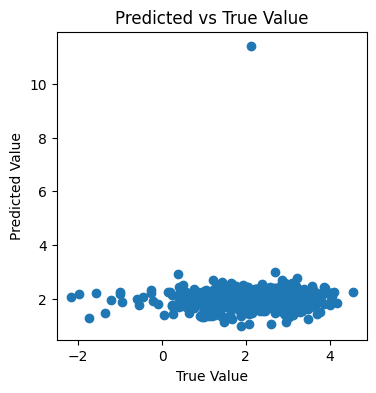

In [77]:
# make prediction 

y_pred = net.predict(feature_data_numpy)

# plot the output against the target

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(4, 4))
plt.scatter(label_data_numpy, y_pred)
plt.xlabel('True Value')
plt.ylabel('Predicted Value')
plt.title('Predicted vs True Value')
# plt.xlim(-2, 4)
# plt.ylim(0, 4)
plt.show()

In [78]:
# calculate pearson correlation

from scipy.stats import pearsonr

corr, _ = pearsonr(label_data_numpy.flatten(), y_pred.flatten())

print(f'Pearsons correlation: {corr}')

Pearsons correlation: 0.08787286256209878


### Integration with Powerkit

In [32]:
from toolkit import *   

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [48]:
powerkit = Powerkit(feature_data, label_data)
rngs = list(range(10))

def pipeline_func(X_train, y_train, rng, **kwargs):
    group_feat_size = 10
    total_feat_size = 260

    net = NeuralNetRegressor(
        TorchModel,
        module__group_feat_size=group_feat_size,
        module__total_feat_size=total_feat_size,
        optimizer=torch.optim.Adam,
        criterion=torch.nn.MSELoss,
        max_epochs=20,
        lr=0.001,
        batch_size=32,
        iterator_train__shuffle=True
    )
    
    x_train_numpy = X_train.to_numpy()
    y_train_numpy = y_train.to_numpy()
    y_train_numpy = y_train_numpy.reshape(-1, 1)
    net.fit(x_train_numpy, y_train_numpy)
    return {'model': net}


def eval_func(X_test, y_test, pipeline_components=None, **kwargs):
    
    # preprocess x and y 
    x_test_numpy = X_test.to_numpy()
    y_test_numpy = y_test.to_numpy()
    y_test_numpy = y_test_numpy.reshape(-1, 1)
    
    net = pipeline_components['model']
    y_pred = net.predict(x_test_numpy)
    # assess performance by pearson correlation
    corr, p_vals = pearsonr(y_test_numpy.flatten(), y_pred.flatten())
    return {'model_performance': corr, 'p_vals': p_vals, 'feature_importance': None}

In [49]:
powerkit.add_condition('pytorch', False, pipeline_func, {}, eval_func, {})

In [50]:
powerkit.run_selected_condition('pytorch', rngs, n_jobs=1)

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        5.0793   647511.4390  0.1363
      2        2.5949   394832.1879  0.1009
      3        1.5954   297385.5756  0.1120
      4        1.2479   244040.5935  0.0982
      5        1.1231   227604.9333  0.1022
      6        1.0434   209151.3628  0.0990
      7        1.0122   232951.1218  0.1009
      8        0.9804   249600.1023  0.0977
      9        0.9694   268425.7829  0.0994
     10        0.9696   286477.7092  0.1145
     11        0.9602   347677.9697  0.0981
     12        0.9372   387715.2953  0.1003
     13        0.9246   402857.7601  0.1032
     14        0.9338   422894.7785  0.0990
     15        0.9087   423071.4449  0.1004
     16        0.9039   455659.7200  0.1031
     17        0.9159   436020.9033  0.1034
     18        0.9039   437892.3736  0.0993
     19        0.9087   421148.2441  0.0996
     20        0.8908   403154.4567  0.1053
  epoch    train_loss    valid_l

,rng,condition,model_performance,p_vals
0,0,pytorch,0.245532,0.045208
1,1,pytorch,0.048639,0.695896
2,2,pytorch,-0.048959,0.693993
3,3,pytorch,-0.081683,0.511104
4,4,pytorch,0.090634,0.465748
...,...,...,...,...
95,95,pytorch,-0.033826,0.785820
96,96,pytorch,0.179587,0.145899
97,97,pytorch,0.006560,0.957979
98,98,pytorch,0.120309,0.332164
